# 作业1

1. 打开任意一幅灰度图片，计算该图像的图像直方图；
2. 打开任意一幅灰度图片，对该图像进行处理，使得整幅图像变亮10个灰度级；
3. 打开任意一幅灰度图片，在该图像的中心位置画一个半径为半个图像高度或宽度的圆。

## 计算灰度图像的图像直方图

首先导入相关库，并读取图片。

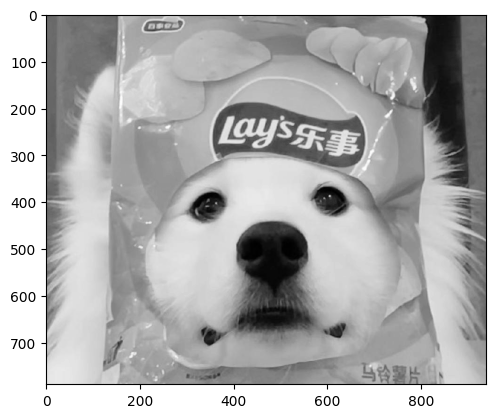

In [5]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import math
 
img = Image.open('./images/samoye2.bmp')#选择自己的图片路径导入
s=np.array(img.convert('L'), dtype=np.int32)#转为灰度图，再转为numpy数组，注意格式用int32，否则默认是uint8(0-255)
grey_img = np.array(img.convert('L'), dtype=np.int32)

plt.imshow(s, cmap='gray')#彩色图转灰度图
plt.show()

In [6]:
def Hist(img):
    #补充相关功能，计算图像尺寸，像素个数，灰度级个数，绘制灰度直方图
    image_size = img.shape
    pixel_num = img.size # .size=.shape[0]*.shape[1]*...
    gray_num = len(np.unique(img)) # .unique从img中列出独一无二的元素
    histogram, _ = np.histogram(img.flatten(), bins=256, range=(0, 256)) # .flatten对数组进行展平，bins表示分组数量，range表示参与分组的数值范围
    
    print(f"图像尺寸：{image_size}")
    print(f"像素个数：{pixel_num}")
    print(f"灰度级个数：{gray_num}")

    plt.bar(np.arange(256), histogram, width=1) # 绘制柱状图，横坐标为0,1,...,255；histogram.shape为(256,)
    plt.xlabel("gray label")
    plt.ylabel("number of pixels")
    plt.axis([0, 255, 0, np.max(histogram)+1000])
    plt.show()

图像尺寸：(789, 940)
像素个数：741660
灰度级个数：256


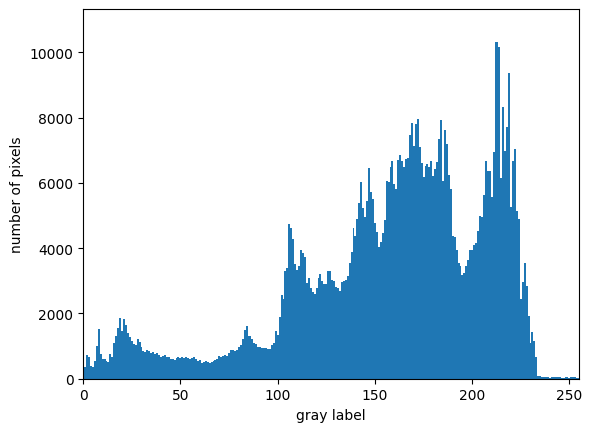

In [7]:
Hist(s)

## 使得整幅灰度图像变亮10个灰度级

In [8]:
def grayboost(img):
    #补充相关功能
    img = img + 10 # 变亮10个灰度级
    img = np.clip(img, 0, 255) # 裁剪
    
    plt.imshow(img, cmap='gray')  # 显示处理后的图像
    plt.show()

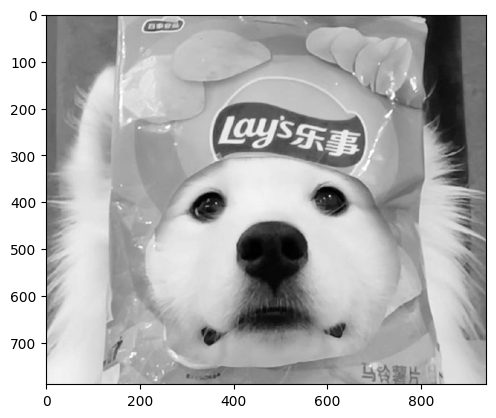

In [9]:
grayboost(s)

## 在灰度图像的中心位置画一个半径为半个图像高度或宽度的圆

In [10]:
def circle(a, b, r):
    def get_y(x):
        nonlocal a, b, r # a,b,r来自于上层函数
        y1 = b + math.sqrt(r**2 - (x - a)**2)
        y2 = b - math.sqrt(r**2 - (x - a)**2)
        return math.floor(y1), math.floor(y2)
    return get_y

def drawcircle(img):
    #补充相关功能
    height = img.shape[0]
    length = img.shape[1]
    r = math.floor(min(length-1, height-1)/2)
    a = math.floor(length/2) # 圆心横坐标
    b = math.floor(height/2) # 圆心纵坐标
    circle_func = circle(a, b, r)
    for x in range(a-r, a+r):
        y1, y2 = circle_func(x)
        img[y1][x]=0
        img[y2][x]=0
    plt.imshow(img, cmap="gray")
    plt.show()

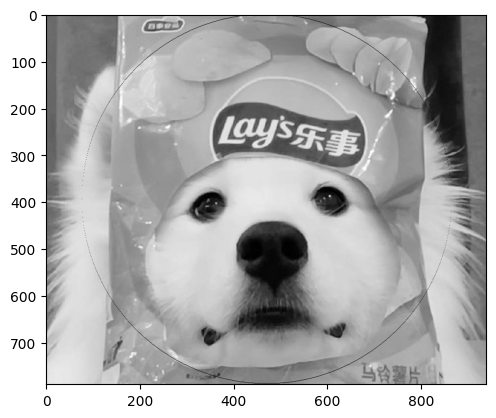

In [11]:
drawcircle(s)

# 作业2

1. 打开任意一幅灰度图片，计算该图像的图像直方图并均衡化
2. 编程实现卷积函数
3. 调用自写卷积函数，实现图像平滑和锐化

## 均衡化灰度图像直方图
直方图均衡化的作用：使得图像灰度级跨越更宽的灰度级范围，从而提高图像对比度

In [12]:
def equalizeHist(img):
    histogram, _ = np.histogram(img.flatten(), bins=256, range=(0, 256)) # .flatten对数组进行展平，bins表示分组数量，range表示参与分组的数值范围
    pixel_num = sum(histogram)
    scare_histogram = histogram/pixel_num # 归一化直方图
    sum_histogram = scare_histogram # 累计直方图
    for i in range(len(scare_histogram)):
        if i == 0:
            sum_histogram[i] = scare_histogram[i]
        else:
            sum_histogram[i] = sum_histogram[i-1] + scare_histogram[i]
    equ_histogram = np.zeros(len(histogram)) # 直方图均衡化
    for i in range(len(histogram)):
        equ_histogram[round(255*sum_histogram[i])]=equ_histogram[round(255*sum_histogram[i])]+histogram[i]

    plt.bar(np.arange(256), equ_histogram, width=1) # 绘制柱状图，横坐标为0,1,...,255；histogram.shape为(256,)
    plt.xlabel("gray label")
    plt.ylabel("number of pixels")
    plt.axis([0, 255, 0, np.max(equ_histogram)])
    plt.show()

    return(sum_histogram)


图像尺寸：(789, 940)
像素个数：741660
灰度级个数：256


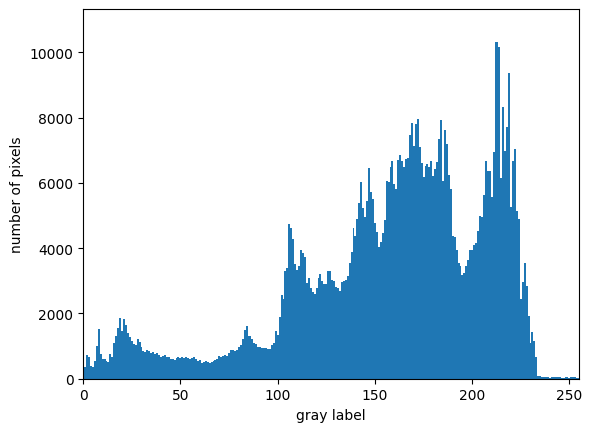

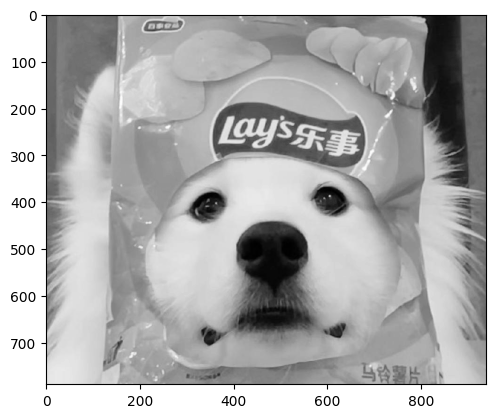

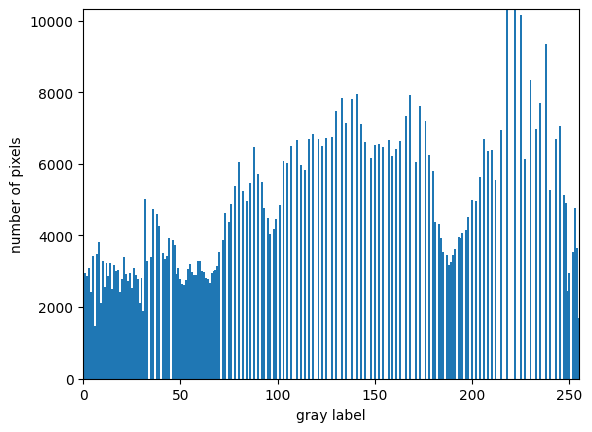

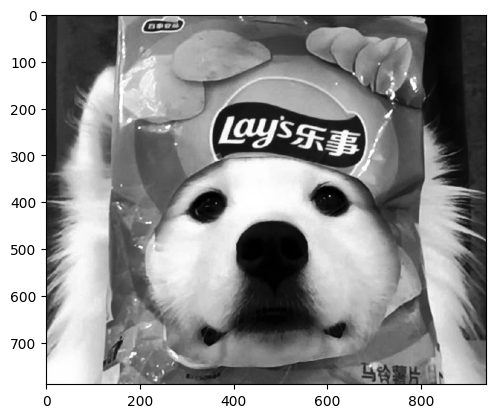

In [13]:
Hist(grey_img)
plt.imshow(grey_img, cmap='gray')#彩色图转灰度图
plt.show()  

sum_histogram = equalizeHist(grey_img)

equ_s = np.zeros(grey_img.shape)
rows, cols = grey_img.shape
for i in range(rows):
    for j in range(cols):
        equ_s[i][j] = round(255*sum_histogram[grey_img[i][j]])

plt.imshow(equ_s, cmap='gray')#彩色图转灰度图
plt.show()    

## 实现卷积函数，并对图像进行平滑和锐化

### 实现卷积函数

In [14]:
def conv2d(input, kernel, bias=0, stride=1, padding=0):
    # input可以是图像经数组化的二维矩阵，kernel为卷积核本身输入，函数应可计算图像尺寸，改写卷积核，偏置，步长和填充。
    
    # 输入图像和卷积核的维度
    input_height, input_width = input.shape
    kernel_height, kernel_width = kernel.shape

    # 计算输出图像的尺寸
    output_height = int(((input_height - kernel_height + 2 * padding) / stride) + 1)
    output_width = int(((input_width - kernel_width + 2 * padding) / stride) + 1)

    # 创建一个用于存储卷积结果的数组
    output = np.zeros((output_height, output_width))

    # 应用填充
    if padding > 0:
        input = np.pad(input, padding, mode='constant') # 填充常数，默认为0

    # 进行卷积操作
    for i in range(0, input_height - kernel_height + 1, stride):
        for j in range(0, input_width - kernel_width + 1, stride):
            output[i, j] = np.sum(input[i:i+kernel_height, j:j+kernel_width] * kernel) + bias

    return output


### 图像平滑和锐化

#### 图像平滑（高斯滤波器）
<div align=left><img src="./images/1.jpg" width="40%" ></img></div>

In [15]:
def smooth(img, kernel):
    process_img = conv2d(img, kernel, 0, 1, 1)
    plt.figure(figsize=(12,6))
    plt.subplot(121)
    plt.imshow(img, cmap='gray')
    plt.subplot(122)
    plt.imshow(process_img, cmap='gray')#彩色图转灰度图
    plt.show()

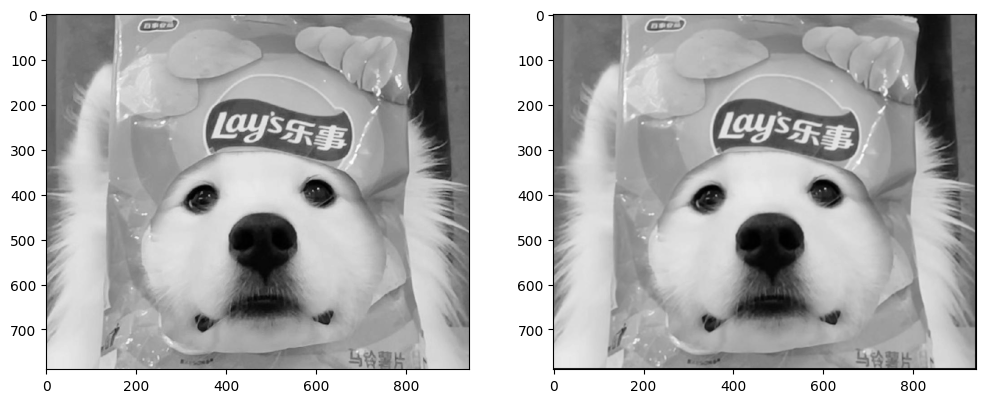

In [16]:
kernel = 1/16 * np.array([[1,2,1],[2,4,2],[1,2,1]])
smooth(grey_img, kernel)

#### 图像锐化（拉普拉斯滤波器）
<div align=left><img src="./images/2.jpg" width="40%" ></img></div>

In [17]:
def sharpen(img, kernel):
    process_img = conv2d(img, kernel, 0, 1, 1)

    min_pixel = np.min(process_img)
    max_pixel = np.max(process_img)
    stretched_image = ((process_img - min_pixel) / (max_pixel - min_pixel)) * 255
    stretched_image = stretched_image.astype(np.uint8)  # 转换为0-255之间的整数

    plt.figure(figsize=(12,6))
    plt.subplot(121)
    plt.imshow(img, cmap='gray')
    plt.subplot(122)
    plt.imshow(process_img, cmap='gray')#彩色图转灰度图
    plt.show()

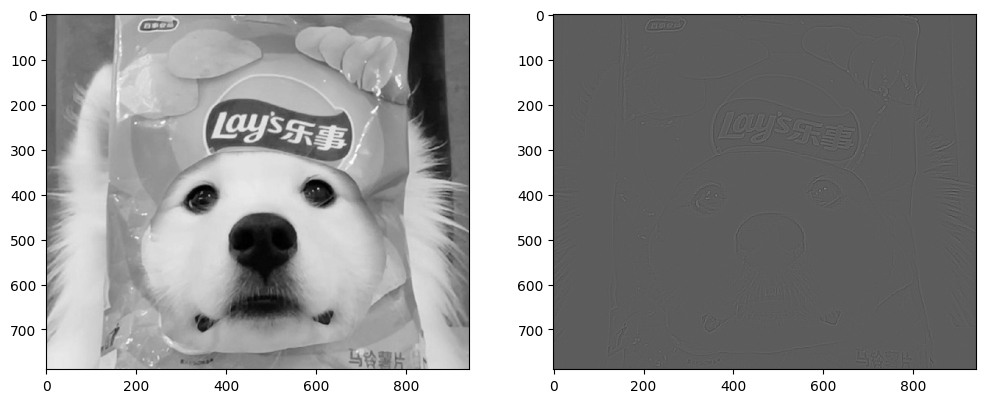

In [18]:
kernel = np.array([[0,-1,0],[-1,4,-1],[0,-1,0]])
sharpen(grey_img, kernel)

# 作业3
1. 给定一方差，编制三个函数，分别生成高斯滤波器、DOG和LOG滤波器
2. 打开任意一幅灰度图片，用生成的滤波器，对其进行滤波并显示
3. 编程实现Harris角点检测算法

## 卷积核生成函数

### 高斯滤波
<div align=left><img src="./images/4.jpg" width="40%" ></img></div> 

In [19]:
def gaussian_filter(sigma, size):
    middle = (size + 1)/2
    gaussian_function = lambda x,y : (1/(2*np.pi*sigma**2)) * np.exp(-((x**2 + y**2)/(2*sigma**2)))
    gau_filter = np.zeros((size, size))
    for i in range(size):
        for j in range(size):
            gau_filter[i][j] = gaussian_function(i-middle+1, j-middle+1)
    return gau_filter / np.sum(gau_filter)

### DOG滤波
1. 当两个不同尺度的高斯滤波器相减时，得到的是一个差异滤波器，即差分高斯滤波器（Difference of Gaussians，简称DOG）。
2. DOG滤波器的响应对于图像中的边缘具有很强的响应，这是因为高斯滤波器在平滑图像时会模糊边缘，而不同尺度的高斯滤波器相减可以突出边缘的差异。通过相减操作，DOG滤波器将增强图像中的边缘和纹理信息。

In [20]:
def dog_filter(sigma1, sigma2, size):
    gaussian1 = gaussian_filter(sigma1, size)
    gaussian2 = gaussian_filter(sigma2, size)
    return gaussian1 - gaussian2

### LOG滤波
1. LOG（Laplacian of Gaussian）滤波器可以被看作是对经过高斯滤波的图像进行二阶导数操作。
2. LOG滤波器首先对图像应用高斯滤波，这可以平滑图像并减少噪声。然后，对经过高斯滤波的图像计算拉普拉斯算子（二阶导数），得到LOG滤波器的响应。
3. LOG滤波器结合了高斯滤波器的平滑效果和拉普拉斯算子的边缘响应，从而可以同时检测图像中的边缘和纹理等特征。
<div align=left><img src="./images/6.jpg" width="20%" ></img></div>
推导如下 
<div align=left><img src="./images/5.jpg" width="40%" ></img></div> 

#### 其它
1. [为什么LOG能不受噪声点的干扰](https://zhuanlan.zhihu.com/p/446286009)
2. [卷积理解](https://www.bilibili.com/video/BV1Yk4y1K7Az/?spm_id_from=333.788.recommend_more_video.4&vd_source=1eb8405e2f113fd061b3a0e8e08d69be)
   1. 一个函数f(x)不动，另一个函数g(a-x)从左往右滑动卷积(对x从负无穷到正无穷积分)
   2. 取定一个a，此时构造一个新函数h(x)，其值为`f(x)g(a-x)`，则此时`f*g(a)`等于h(x)对x从负无穷到正无穷卷积，即`f(x)g(a-x)`与x轴围成的面积(上正下负)，这样a从负无穷遍历到正无穷就能得到`f*g(x)`的结果

In [21]:
def log_filter(sigma, size):
    middle = (size+1)/2
    log_function = lambda x,y : -1 / (np.pi*sigma**4) * (1 - ((x**2 + y**2) / (2*sigma**2))) * np.exp(-(x**2 + y**2) / (2*sigma**2))
    filter = np.zeros((size, size))
    for i in range(size):
        for j in range(size):
            filter[i][j] = log_function(i-middle+1, j-middle+1)
    return filter

## 滤波显示

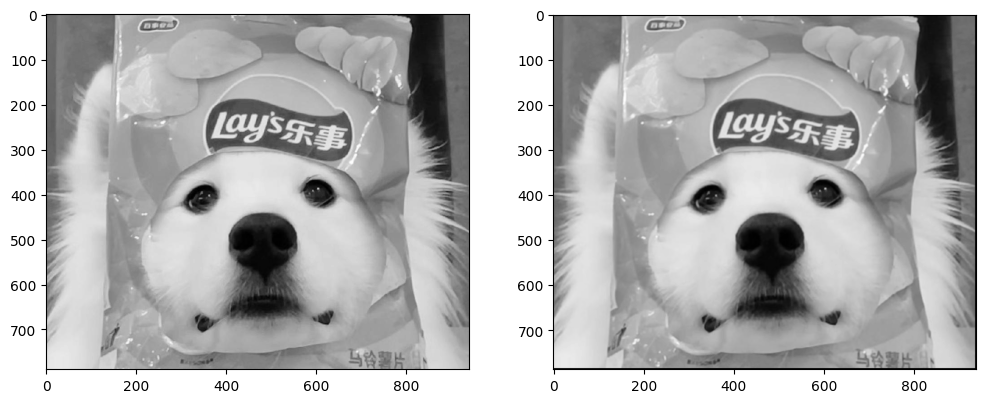

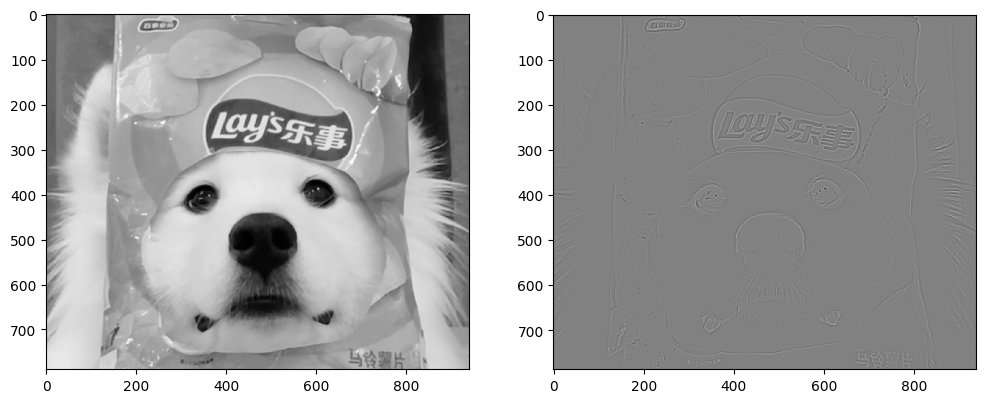

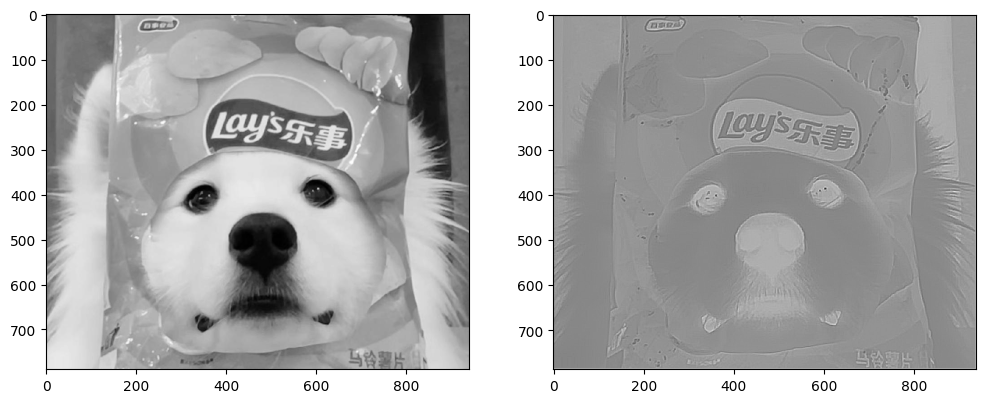

In [22]:
gau_filter = gaussian_filter(0.8, 5)
DOG_filter = dog_filter(0.8, 0.4, 5)
LOG_filter = log_filter(0.9, 5)
sharpen(grey_img, gau_filter)
sharpen(grey_img, DOG_filter)
sharpen(grey_img, LOG_filter)

## Harris角点检测算法
<div align=left><img src="./images/7.jpg" width="30%" ></img></div> 

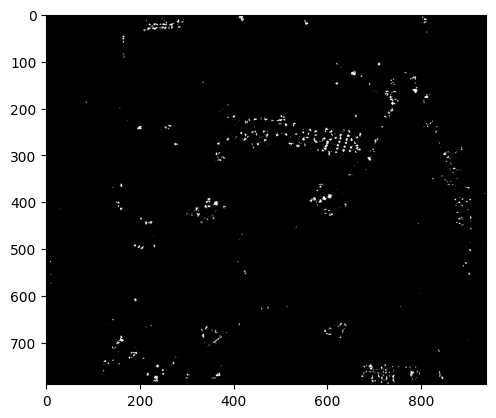

In [23]:
import cv2
import numpy as np

def harris_corner_detection(image, k=0.04, threshold=0.01):
    # 计算图像每个点的梯度
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)

    # 计算协方差矩阵H的每个元素
    Ixx = sobelx**2
    Iyy = sobely**2
    Ixy = sobelx * sobely

    # 计算协方差矩阵H的每个元素的和（目的是平滑梯度信息，获取局部像素梯度，得到局部像素协方差矩阵）
    window_size = 3
    kernel = np.ones((window_size, window_size))
    Sxx = cv2.filter2D(Ixx, -1, kernel)
    Syy = cv2.filter2D(Iyy, -1, kernel)
    Sxy = cv2.filter2D(Ixy, -1, kernel)

    # 计算每个像素的Harris响应值
    det = Sxx * Syy - Sxy**2 # 特征值乘积为行列式
    trace = Sxx + Syy # 特征值之和为迹
    harris_response = det - k * (trace**2)
    
    # 只保留大于阈值的角点
    corners = np.zeros_like(image)
    corners[harris_response > threshold * harris_response.max()] = 255
    return corners

# 读取图像
harris_image = cv2.imread('./images/samoye2.bmp', 0)  # 灰度图像

# 执行Harris角点检测
corners = harris_corner_detection(harris_image, threshold=0.001)

# 显示结果
plt.imshow(corners, cmap='gray')
plt.show()

# 作业4

## 斑点检测算法
1. 斑点检测算子如下，相当于[LOG滤波](homework.ipynb#log滤波)乘上一个规范化系数，即方差的平方
   <div align=left><img src="./images/8.jpg" width="30%" ></img></div>

2. 原理
   1. 理解1：图像与某一个二维函数进行卷积运算实际就是求取图像与这一函数的相似性。同理，图像与高斯拉普拉斯的卷积实际就是求取图像与高斯拉普拉斯函数的相似性。当图像中斑点尺寸与函数形状趋向一致时，响应最大。
   2. 理解2：LOG滤波有去噪的作用，去噪的原理在于LOG算子的宽度远大于噪声的宽度，使得积分结果变小，进而消除噪声，乘上一个规范化系数能够保证LOG滤波宽度增大（能够框住更多斑点）的同时积分结果不变小（乘上一个大于0的数？）
3. [参考文章](https://zhuanlan.zhihu.com/p/448959603)

In [24]:
def blob_detector(sigma, size):
    middle = (size+1)//2
    log_function = lambda x,y : 1 / (np.pi*sigma**4) * (1 - ((x**2 + y**2) / (2*sigma**2))) * np.exp(-(x**2 + y**2) / (2*sigma**2)) * sigma**2
    filter = np.zeros((size, size))
    for i in range(size):
        for j in range(size):
            filter[i][j] = log_function(i-middle+1, j-middle+1)
    return filter

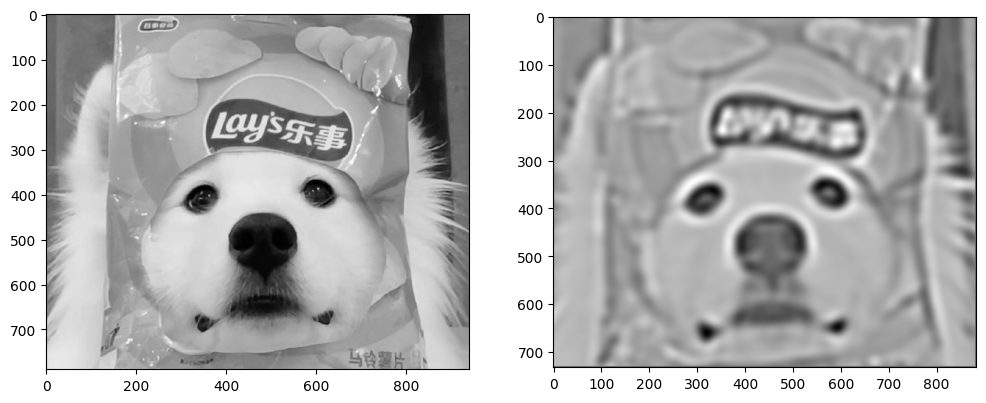

In [25]:
BLOB_detector = blob_detector(11.9912, 60)
sharpen(grey_img, BLOB_detector)

## SIFT点提取及描述算法
> 算法实现参考[视频](https://www.bilibili.com/video/BV1Qb411W7cK/?p=5&share_source=copy_web&vd_source=215965f7b38b7ce4a7fec78846a6acd0)
1. 尺度空间极值检测
   1. 获取高斯金字塔
      1. 采样获取每层图片
      2. 每层图片使用不同程度的高斯滤波进行模糊
   2. 对每层的图片进行差分，得到差分图像DOG，进而获取差分金字塔
      <div align=left><img src="./images/9.jpg" width="30%" ></img></div>
   3. 空间极值检测，例如×比周围的26个○都大，为极值
      <div align=left><img src="./images/10.jpg" width="30%" ></img></div>
      <div align=left><img src="./images/11.jpg" width="30%" ></img></div>
2. 关键点定位：通过插值找到极值点坐标
3. 方向赋值：计算极值点附近的梯度方向和梯度幅值，得到极值点主方向
   <div align=left><img src="./images/12.jpg" width="30%" ></img></div>
4. 关键点描述：将极值点周围区域的像素根据极值点主方向进行选转（保证旋转不变性），统计区域中子区域梯度方向，同时累计幅值
   <div align=left><img src="./images/13.jpg" width="30%" ></img></div>
   <div align=left><img src="./images/14.jpg" width="30%" ></img></div>


In [2]:
import warnings
warnings.filterwarnings("ignore")  #忽略警告
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from PIL import Image

# 卷积函数
# filter：卷积核
# mat：输入矩阵
# padding：填充
# strides：步长
def convolve(filter,mat,padding,strides):
    result = None
    filter_size = filter.shape
    mat_size = mat.shape
    if len(filter_size) == 2: # 确保卷积核维度为2维
        if len(mat_size) == 3: # 输入图像有通道
            channel = []
            for i in range(mat_size[-1]):
                pad_mat = np.pad(mat[:,:,i], ((padding[0], padding[1]), (padding[2], padding[3])), 'constant')
                temp = []
                for j in range(0,mat_size[0],strides[1]):
                    temp.append([])
                    for k in range(0,mat_size[1],strides[0]):
                        val = (filter*pad_mat[j:j+filter_size[0],k:k+filter_size[1]]).sum()
                        temp[-1].append(val)
                channel.append(np.array(temp))
            channel = tuple(channel)
            result = np.dstack(channel)
       
        elif len(mat_size) == 2:
            channel = []
            pad_mat = np.pad(mat, ((padding[0], padding[1]), (padding[2], padding[3])), 'constant')
            for j in range(0, mat_size[0], strides[1]):
                channel.append([])
                for k in range(0, mat_size[1], strides[0]):
                    val = (filter * pad_mat[j:j + filter_size[0],k:k + filter_size[1]]).sum()
                    channel[-1].append(val)
            result = np.array(channel)

    return result # (height, weight, channels)，channels不一定有


# 下采样，采样间隔为2，每2个像素点取一个样
def downsample(img,step = 2):
    step = int(step)
    return img[::step,::step]

# 生成高斯核
def GuassianKernel(sigma , dim):
    temp = [t - (dim//2) for t in range(dim)] # [-4,-3,-2,-1,0,1,2,3,4]
    assistant = []
    for _ in range(dim):
        assistant.append(temp)
    assistant = np.array(assistant)
    temp = 2*sigma*sigma
    result = (1.0/(temp*np.pi))*np.exp(-(assistant**2+(assistant.T)**2)/temp) # assistant为x，其转置为y
    return result

# 构建高斯差分金字塔
# img：原始图像
# n：提取的特征数量
# sigma0：第一个尺度的标准差
# S：每层的尺度数量
# O：层数
def getDoG(img,n,sigma0,S = None,O = None):
    if S == None:
        S = n + 3 
    if O == None:
        O = int(np.log2(min(img.shape[0], img.shape[1]))) - 3

    k = 2 ** (1.0 / n)
    sigma = [[(k**s)*sigma0*(1<<o) for s in range(S)] for o in range(O)] # 标准差金字塔，1<<o实际就是2的o次方，层数越高尺度越大（层数越高分辨率越低，需要的方差越大）
    samplePyramid = [downsample(img, 1 << o) for o in range(O)]

    GuassianPyramid = []
    for i in range(O):
        GuassianPyramid.append([])
        for j in range(S):
            dim = int(6*sigma[i][j] + 1)
            if dim % 2 == 0:
                dim += 1
            GuassianPyramid[-1].append(convolve(GuassianKernel(sigma[i][j], dim),samplePyramid[i],[dim//2,dim//2,dim//2,dim//2],[1,1])) # 改：[1,1] -> [2,2]
    DoG = [[GuassianPyramid[o][s+1] - GuassianPyramid[o][s] for s in range(S - 1)] for o in range(O)]
    return DoG,GuassianPyramid

# 关键点定位
# 参数解释：DOG金字塔、当前八度（层数）、当前层级（尺度）、关键点初始x、初始y、对比度阈值、边缘阈值、高斯尺度、尺度数量
# 每层的一组图像称为一个八度，一个八度下有不同尺度的图像
def adjustLocalExtrema(DoG,o,s,x,y,contrastThreshold,edgeThreshold,sigma,n,SIFT_FIXPT_SCALE):
    SIFT_MAX_INTERP_STEPS = 5
    SIFT_IMG_BORDER = 5

    point = []

    img_scale = 1.0 / (255 * SIFT_FIXPT_SCALE)
    deriv_scale = img_scale * 0.5
    second_deriv_scale = img_scale
    cross_deriv_scale = img_scale * 0.25

    img = DoG[o][s]
    i = 0
    while i < SIFT_MAX_INTERP_STEPS:
        if s < 1 or s > n or y < SIFT_IMG_BORDER or y >= img.shape[1] - SIFT_IMG_BORDER or x < SIFT_IMG_BORDER or x >= img.shape[0] - SIFT_IMG_BORDER:
            return None,None,None,None

        img = DoG[o][s]
        prev = DoG[o][s - 1]
        next = DoG[o][s + 1]

        dD = [ (img[x,y + 1] - img[x, y - 1]) * deriv_scale,
               (img[x + 1, y] - img[x - 1, y]) * deriv_scale,
               (next[x, y] - prev[x, y]) * deriv_scale ]

        v2 = img[x, y] * 2
        dxx = (img[x, y + 1] + img[x, y - 1] - v2) * second_deriv_scale
        dyy = (img[x + 1, y] + img[x - 1, y] - v2) * second_deriv_scale
        dss = (next[x, y] + prev[x, y] - v2) * second_deriv_scale
        dxy = (img[x + 1, y + 1] - img[x + 1, y - 1] - img[x - 1, y + 1] + img[x - 1, y - 1]) * cross_deriv_scale
        dxs = (next[x, y + 1] - next[x, y - 1] - prev[x, y + 1] + prev[x, y - 1]) * cross_deriv_scale
        dys = (next[x + 1, y] - next[x - 1, y] - prev[x + 1, y] + prev[x - 1, y]) * cross_deriv_scale

        H=[ [dxx, dxy, dxs],
            [dxy, dyy, dys],
            [dxs, dys, dss]]

        X = np.matmul(np.linalg.pinv(np.array(H)),np.array(dD))

        xi = -X[2]
        xr = -X[1]
        xc = -X[0]

        if np.abs(xi) < 0.5 and np.abs(xr) < 0.5 and np.abs(xc) < 0.5:
            break

        y += int(np.round(xc))
        x += int(np.round(xr))
        s += int(np.round(xi))

        i+=1
    
    # 对比相邻像素，寻找局部最值点
    if i >= SIFT_MAX_INTERP_STEPS:
        return None,x,y,s
    if s < 1 or s > n or y < SIFT_IMG_BORDER or y >= img.shape[1] - SIFT_IMG_BORDER or x < SIFT_IMG_BORDER or x >= \
            img.shape[0] - SIFT_IMG_BORDER:
        return None, None, None, None


    t = (np.array(dD)).dot(np.array([xc, xr, xi]))

    contr = img[x,y] * img_scale + t * 0.5
    if np.abs( contr) * n < contrastThreshold:
        return None,x,y,s


    # 利用Hessian矩阵的迹和行列式计算主曲率的比值
    # Hessian矩阵描述了局部二阶空间变化，特征值的和为迹，乘积为行列式，特征值都大为角点，特征值都小为平坦，特征值一大一小为边缘
    tr = dxx + dyy
    det = dxx * dyy - dxy * dxy
    if det <= 0 or tr * tr * edgeThreshold >= (edgeThreshold + 1) * (edgeThreshold + 1) * det:
        return None,x,y,s

    point.append((x + xr) * (1 << o))
    point.append((y + xc) * (1 << o))
    point.append(o + (s << 8) + (int(np.round((xi + 0.5)) * 255) << 16))
    point.append(sigma * np.power(2.0, (s + xi) / n)*(1 << o) * 2)

    return point,x,y,s # point中包含了关键点坐标（原始坐标）和层级、尺度，x、y为关键点坐标（尺度坐标）

# 找到关键点的主方向
# radius为领域半径
# binnum表示梯度方向数量
def GetMainDirection(img,r,c,radius,sigma,BinNum):
    expf_scale = -1.0 / (2.0 * sigma * sigma)

    X = []
    Y = []
    W = []
    temphist = []

    for i in range(BinNum):
        temphist.append(0.0)

    # 图像梯度直方图统计的像素范围
    k = 0
    for i in range(-radius,radius+1):
        y = r + i
        if y <= 0 or y >= img.shape[0] - 1:
            continue
        for j in range(-radius,radius+1):
            x = c + j
            if x <= 0 or x >= img.shape[1] - 1:
                continue

            dx = (img[y, x + 1] - img[y, x - 1])
            dy = (img[y - 1, x] - img[y + 1, x])

            X.append(dx)
            Y.append(dy)
            W.append((i * i + j * j) * expf_scale)
            k += 1

    length = k

    W = np.exp(np.array(W))
    Y = np.array(Y)
    X = np.array(X)
    Ori = np.arctan2(Y,X)*180/np.pi
    Mag = (X**2+Y**2)**0.5

    # 计算直方图的每个bin
    for k in range(length):
        bin = int(np.round((BinNum / 360.0) * Ori[k]))
        if bin >= BinNum:
            bin -= BinNum
        if bin < 0:
            bin += BinNum
        temphist[bin] += W[k] * Mag[k]

    # smooth the histogram
    # 高斯平滑
    temp = [temphist[BinNum - 1], temphist[BinNum - 2], temphist[0], temphist[1]]
    temphist.insert(0, temp[0])
    temphist.insert(0, temp[1])
    temphist.insert(len(temphist), temp[2])
    temphist.insert(len(temphist), temp[3])      # padding

    hist = []
    for i in range(BinNum):
        hist.append((temphist[i] + temphist[i+4]) * (1.0 / 16.0) + (temphist[i+1] + temphist[i+3]) * (4.0 / 16.0) + temphist[i+2] * (6.0 / 16.0))

    # 得到主方向
    maxval = max(hist)

    return maxval,hist

def LocateKeyPoint(DoG,sigma,GuassianPyramid,n,BinNum = 36,contrastThreshold = 0.04,edgeThreshold = 10.0):
    SIFT_ORI_SIG_FCTR = 1.52
    SIFT_ORI_RADIUS = 3 * SIFT_ORI_SIG_FCTR
    SIFT_ORI_PEAK_RATIO = 0.8

    SIFT_INT_DESCR_FCTR = 512.0
    # SIFT_FIXPT_SCALE = 48
    SIFT_FIXPT_SCALE = 1

    KeyPoints = []
    O = len(DoG)
    S = len(DoG[0])

    # 遍历每个八度的每个尺度
    for o in range(O):
        for s in range(1,S-1):
            threshold = 0.5*contrastThreshold/(n*255*SIFT_FIXPT_SCALE)
            img_prev = DoG[o][s-1]
            img = DoG[o][s]
            img_next = DoG[o][s+1]
            for i in range(img.shape[0]):
                for j in range(img.shape[1]):
                    val = img[i,j]
                    eight_neiborhood_prev = img_prev[max(0, i - 1):min(i + 2, img_prev.shape[0]), max(0, j - 1):min(j + 2, img_prev.shape[1])]
                    eight_neiborhood = img[max(0, i - 1):min(i + 2, img.shape[0]), max(0, j - 1):min(j + 2, img.shape[1])]
                    eight_neiborhood_next = img_next[max(0, i - 1):min(i + 2, img_next.shape[0]), max(0, j - 1):min(j + 2, img_next.shape[1])]
                    
                    # 判断是否为极值点
                    if np.abs(val) > threshold and \
                        ((val > 0 and (val >= eight_neiborhood_prev).all() and (val >= eight_neiborhood).all() and (val >= eight_neiborhood_next).all())
                         or (val < 0 and (val <= eight_neiborhood_prev).all() and (val <= eight_neiborhood).all() and (val <= eight_neiborhood_next).all())):

                        # 通过插值调整极值点位置
                        point,x,y,layer = adjustLocalExtrema(DoG,o,s,i,j,contrastThreshold,edgeThreshold,sigma,n,SIFT_FIXPT_SCALE)
                        if point == None:
                            continue

                        scl_octv = point[-1]*0.5/(1 << o)
                        
                        # 计算主方向
                        omax,hist = GetMainDirection(GuassianPyramid[o][layer],x,y,int(np.round(SIFT_ORI_RADIUS * scl_octv)),SIFT_ORI_SIG_FCTR * scl_octv,BinNum)
                        mag_thr = omax * SIFT_ORI_PEAK_RATIO
                        for k in range(BinNum):
                            if k > 0:
                                l = k - 1
                            else:
                                l = BinNum - 1
                            if k < BinNum - 1:
                                r2 = k + 1
                            else:
                                r2 = 0
                            if hist[k] > hist[l] and hist[k] > hist[r2] and hist[k] >= mag_thr:
                                bin = k + 0.5 * (hist[l]-hist[r2]) /(hist[l] - 2 * hist[k] + hist[r2])
                                if bin < 0:
                                    bin = BinNum + bin
                                else:
                                    if bin >= BinNum:
                                        bin = bin - BinNum
                                temp = point[:]
                                temp.append((360.0/BinNum) * bin)
                                KeyPoints.append(temp)
    return KeyPoints # 包含point、x、y（层级坐标）、层级、主方向

# 计算SIFT描述符，返回值为128维向量（4*4网格，每个网格有8个梯度方向的幅值）
def calcSIFTDescriptor(img,ptf,ori,scl,d,n,SIFT_DESCR_SCL_FCTR = 3.0,SIFT_DESCR_MAG_THR = 0.2,SIFT_INT_DESCR_FCTR = 512.0,FLT_EPSILON = 1.19209290E-07):
    dst = []
    pt = [int(np.round(ptf[0])), int(np.round(ptf[1]))] # 坐标点取整
    cos_t = np.cos(ori * (np.pi / 180)) # 余弦值
    sin_t = np.sin(ori * (np.pi / 180)) # 正弦值
    bins_per_rad = n / 360.0
    exp_scale = -1.0 / (d * d * 0.5)
    hist_width = SIFT_DESCR_SCL_FCTR * scl
    radius = int(np.round(hist_width * 1.4142135623730951 * (d + 1) * 0.5))
    cos_t /= hist_width
    sin_t /= hist_width

    rows = img.shape[0]
    cols = img.shape[1]


    hist = [0.0]*((d+2)*(d+2)*(n+2))
    X = []
    Y = []
    RBin = []
    CBin = []
    W = []

    k = 0
    for i in range(-radius,radius+1):
        for j in range(-radius,radius+1):

            c_rot = j * cos_t - i * sin_t
            r_rot = j * sin_t + i * cos_t
            rbin = r_rot + d // 2 - 0.5
            cbin = c_rot + d // 2 - 0.5
            r = pt[1] + i
            c = pt[0] + j

            if rbin > -1 and rbin < d and cbin > -1 and cbin < d and r > 0 and r < rows - 1 and c > 0 and c < cols - 1:
                dx = (img[r, c+1] - img[r, c-1])
                dy = (img[r-1, c] - img[r+1, c])
                X.append(dx)
                Y.append(dy)
                RBin.append(rbin)
                CBin.append(cbin)
                W.append((c_rot * c_rot + r_rot * r_rot) * exp_scale)
                k+=1

    length = k
    Y = np.array(Y)
    X = np.array(X)
    Ori = np.arctan2(Y,X)*180/np.pi
    Mag = (X ** 2 + Y ** 2) ** 0.5
    W = np.exp(np.array(W))

    for k in range(length):
        rbin = RBin[k]
        cbin = CBin[k]
        obin = (Ori[k] - ori) * bins_per_rad
        mag = Mag[k] * W[k]

        r0 = int(rbin)
        c0 = int(cbin)
        o0 = int(obin)
        rbin -= r0
        cbin -= c0
        obin -= o0

        if o0 < 0:
            o0 += n
        if o0 >= n:
            o0 -= n

        # histogram update using tri-linear interpolation
        v_r1 = mag * rbin
        v_r0 = mag - v_r1

        v_rc11 = v_r1 * cbin
        v_rc10 = v_r1 - v_rc11

        v_rc01 = v_r0 * cbin
        v_rc00 = v_r0 - v_rc01

        v_rco111 = v_rc11 * obin
        v_rco110 = v_rc11 - v_rco111

        v_rco101 = v_rc10 * obin
        v_rco100 = v_rc10 - v_rco101

        v_rco011 = v_rc01 * obin
        v_rco010 = v_rc01 - v_rco011

        v_rco001 = v_rc00 * obin
        v_rco000 = v_rc00 - v_rco001

        idx = ((r0 + 1) * (d + 2) + c0 + 1) * (n + 2) + o0
        hist[idx] += v_rco000
        hist[idx+1] += v_rco001
        hist[idx + (n+2)] += v_rco010
        hist[idx + (n+3)] += v_rco011
        hist[idx+(d+2) * (n+2)] += v_rco100
        hist[idx+(d+2) * (n+2)+1] += v_rco101
        hist[idx+(d+3) * (n+2)] += v_rco110
        hist[idx+(d+3) * (n+2)+1] += v_rco111

    # finalize histogram, since the orientation histograms are circular
    for i in range(d):
        for j in range(d):
            idx = ((i+1) * (d+2) + (j+1)) * (n+2)
            hist[idx] += hist[idx+n]
            hist[idx+1] += hist[idx+n+1]
            for k in range(n):
                dst.append(hist[idx+k])

    # copy histogram to the descriptor,
    # apply hysteresis thresholding
    # and scale the result, so that it can be easily converted
    # to byte array
    nrm2 = 0
    length = d * d * n
    for k in range(length):
        nrm2 += dst[k] * dst[k]
    thr = np.sqrt(nrm2) * SIFT_DESCR_MAG_THR

    nrm2 = 0
    for i in range(length):
        val = min(dst[i], thr)
        dst[i] = val
        nrm2 += val * val
    nrm2 = SIFT_INT_DESCR_FCTR / max(np.sqrt(nrm2), FLT_EPSILON)
    for k in range(length):
        dst[k] = min(max(dst[k] * nrm2,0),255)

    return dst

# 调用求描述符的函数，返回关键点描述符列表
def calcDescriptors(gpyr,keypoints,SIFT_DESCR_WIDTH = 4,SIFT_DESCR_HIST_BINS = 8):
    # SIFT_DESCR_WIDTH = 4，描述直方图的宽度
    # SIFT_DESCR_HIST_BINS = 8
    d = SIFT_DESCR_WIDTH
    n = SIFT_DESCR_HIST_BINS
    descriptors = []

    for i in range(len(keypoints)):
        kpt = keypoints[i]
        o = kpt[2] & 255
        s = (kpt[2] >> 8) & 255 # 该特征点所在的组序号和层序号
        scale = 1.0 / (1 << o)  # 缩放倍数
        size = kpt[3] * scale # 该特征点所在组的图像尺寸
        ptf = [kpt[1] * scale, kpt[0] * scale] # 该特征点在金字塔组中的坐标
        img = gpyr[o][s] # 该点所在的金字塔图像

        descriptors.append(calcSIFTDescriptor(img, ptf, kpt[-1], size * 0.5, d, n))
    return descriptors

def SIFT(img, showDoGimgs=False):
    SIFT_SIGMA = 1.6
    SIFT_INIT_SIGMA = 0.5 # 假设的摄像头的尺度
    sigma0 = np.sqrt(SIFT_SIGMA**2-SIFT_INIT_SIGMA**2)

    n = 3

    # 构建差分金字塔
    DoG,GuassianPyramid = getDoG(img, n,sigma0)
    
    # 绘制不同八度不同尺度图像
    if showDoGimgs:
        inum = 0
        jnum = 0
        for i in DoG:
            inum = inum + 1
            for j in i:
                jnum = jnum + 1
                print(f"octave:{inum}, scale:{jnum}")
                plt.imshow(j.astype(np.uint8), cmap='gray')
                plt.axis('off')
                plt.show()
    
    # 计算关键点
    KeyPoints = LocateKeyPoint(DoG, SIFT_SIGMA, GuassianPyramid, n)

    # 计算关键点描述符
    discriptors = calcDescriptors(GuassianPyramid,KeyPoints)

    return KeyPoints,discriptors


def Lines(img,info,color = (255,0,0),err = 700):

    if len(img.shape) == 2:
        result = np.dstack((img,img,img))
    else:
        result = img
    k = 0
    for i in range(result.shape[0]):
        for j in range(result.shape[1]):
            temp = (info[:,1]-info[:,0])
            A = (j - info[:,0])*(info[:,3]-info[:,2])
            B = (i - info[:,2])*(info[:,1]-info[:,0])
            temp[temp == 0] = 1e-9
            t = (j-info[:,0])/temp
            e = np.abs(A-B)
            temp = e < err
            if (temp*(t >= 0)*(t <= 1)).any():
                result[i,j] = color
                k+=1
    print(k)

    return result

def drawLines(X1,X2,Y1,Y2,dis,img,num = 10):

    info = list(np.dstack((X1,X2,Y1,Y2,dis))[0])
    info = sorted(info,key=lambda x:x[-1])
    info = np.array(info)
    info = info[:min(num,info.shape[0]),:]
    img = Lines(img,info)
    #plt.imsave('./sift/3.jpg', img)

    if len(img.shape) == 2:
        plt.imshow(img.astype(np.uint8),cmap='gray')
    else:
        plt.imshow(img.astype(np.uint8))
    plt.axis('off')
    #plt.plot([info[:,0], info[:,1]], [info[:,2], info[:,3]], 'c')
    # fig = plt.gcf()
    # fig.set_size_inches(int(img.shape[0]/100.0),int(img.shape[1]/100.0))
    #plt.savefig('./sift/2.jpg')
    plt.show()


# if __name__ == '__main__':
if_showDOG = False

origimg = plt.imread('资料/多张全景拼接/000007.jpg')
if len(origimg.shape) ==  3:
    img = origimg.mean(axis=-1)
else:
    img = origimg
keyPoints,discriptors = SIFT(img)


origimg2 = plt.imread('资料/多张全景拼接/000006.jpg')
if len(origimg.shape) == 3:
    img2 = origimg2.mean(axis=-1)
else:
    img2 = origimg2
ScaleRatio = img.shape[0]*1.0/img2.shape[0]

img2 = np.array(Image.fromarray(img2).resize((int(round(ScaleRatio * img2.shape[1])),img.shape[0]), Image.BICUBIC))

# 使用SIFT算法获取特征点及特征点描述符
keyPoints2, discriptors2 = SIFT(img2,if_showDOG)

print(np.array(keyPoints).shape)
print(np.array(discriptors).shape)

# 非参数估计 分类 k近邻
knn = KNeighborsClassifier(n_neighbors=1) # 创建kNN分类器，k近邻为1
knn.fit(discriptors,[0]*len(discriptors)) # 使用第一个图像的关键点描述符作为k近邻中心点
match = knn.kneighbors(discriptors2,n_neighbors=1,return_distance=True) # 第二个图像的关键点描述符进行匹配，match[0]为最近邻距离，match[1]为最近邻点的索引，shape均为（244,1），代表查询的关键点与训练集最近邻关键点的距离或索引
# match[0]最近邻距离，match[1]最近邻索引 

# 取出关键点的坐标
keyPoints = np.array(keyPoints)[:,:2]
keyPoints2 = np.array(keyPoints2)[:,:2]

# keyPoints2[:, 1] = img.shape[1] + keyPoints2[:, 1]

origimg2 = np.array(Image.fromarray(origimg2).resize((img2.shape[1],img2.shape[0]), Image.BICUBIC))
result = np.hstack((origimg,origimg2))

keyPoints = keyPoints[match[1][:,0]] # match[1][:, 0] 返回了最近邻点在训练集中的索引，然后通过 keyPoints[match[1][:, 0]] 从 keyPoints（训练集）中取出与测试集匹配的最近邻点

# X1 = keyPoints[:, 1]
# X2 = keyPoints2[:, 1]
# Y1 = keyPoints[:, 0]
# Y2 = keyPoints2[:, 0]
# print(keyPoints.shape)
# print(keyPoints2.shape)

# drawLines(X1,X2,Y1,Y2,match[0][:,0],result)

(513, 5)
(513, 128)


# 作业5

## RANSAC算法
### 原理
1. **特征提取和初始匹配：** 使用SIFT从两幅图像中提取特征点，并计算描述符
2. **RANSAC迭代：** 对于RANSAC的每一次迭代，执行以下步骤：
   1. 随机选择样本： 从所有初始匹配中随机选择一小部分样本。
   2. 模型拟合： 使用选择的样本来拟合一个几何变换模型，例如仿射变换或透视变换。
   3. 内点检验： 计算所有匹配点到拟合模型的拟合误差，并标记那些误差小于某个阈值的点为“内点”。
   4. 评估： 如果内点的数量达到了某个预定的阈值或者满足其他停止条件，就认为当前模型是足够好的。
3. **最终结果：** 选择具有最多内点的模型作为最终的匹配模型。将所有内点作为正确的匹配点，而将其他点视为误匹配。
4. **使用最终模型：** 使用最终确定的几何变换模型和内点来进行最终的图像匹配。这可以是通过应用变换将一幅图像中的特征点映射到另一幅图像中，从而实现两幅图像的配准。
### 理解
我们可以这样考虑，两幅图的重叠部分相当于经过了仿射变换，在第一幅图中的特征点都共同落在了一条直线上，在经过仿射变换后，由于仿射变换具有保线性，那么第二幅图中对应的特征点也理所当然地应该落在某条直线上。所以RANSAC其实与直线拟合是没有区别的，即二维平面上的某条直线上的点，经过仿射变换以后变成了同一个平面内的另一条直线上的匹配点，而RANSAC的目的就是排除掉那些在变换过程中出错了的那些野值点（即与仿射变换后的直线距离较远的点）。

(30, 2)
(30, 2)
14041


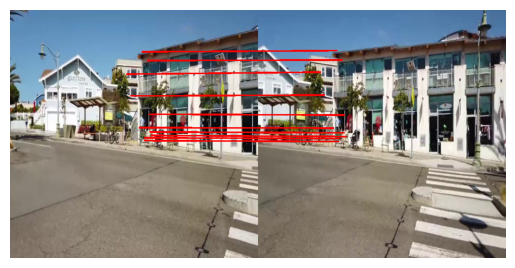

In [27]:
import numpy as np

# 构建增广矩阵，使用最小二乘法估计特征点1到特征点2的模型参数（2*2的矩阵和偏移向量）
def fit_affine_model(src_points, dst_points):
    assert len(src_points) == len(dst_points) >= 3

    A = np.vstack([src_points.T, np.ones(len(src_points))]).T
    model_params, _, _, _ = np.linalg.lstsq(A, dst_points, rcond=None)

    return model_params[:2], model_params[2]

# 将仿射模型应用于特征点1
def apply_affine_model(model_params, src_points):
    return np.dot(src_points, model_params[0]) + model_params[1]

# 测量使用给定仿射模型转换的源点与实际目标点之间的欧几里得距离，计算误差
def compute_residuals(model_params, src_points, dst_points):
    transformed_src_points = apply_affine_model(model_params, src_points)
    residuals = np.linalg.norm(transformed_src_points - dst_points, axis=1)
    return residuals

# 实现RANSAC算法，通过迭代地将模型拟合到数据的随机子集，并选择具有最多内点的模型来找到最佳仿射模型。内点根据提供的阈值确定。
def ransac(src_points, dst_points, max_iterations, inlier_threshold):
    best_model = None
    best_inliers = []

    for iteration in range(max_iterations):
        # 随机选择最小样本
        sample_indices = np.random.choice(len(src_points), size=3, replace=False)
        sample_src = src_points[sample_indices]
        sample_dst = dst_points[sample_indices]

        # 拟合模型（这里假设使用仿射变换）
        model_params = fit_affine_model(sample_src, sample_dst)

        # 计算所有点到模型的距离
        residuals = compute_residuals(model_params, src_points, dst_points)

        # 标记内点
        inliers = residuals < inlier_threshold

        # 如果当前内点数量超过历史最优模型的内点数量
        if np.sum(inliers) > np.sum(best_inliers):
            # 更新最优模型和内点
            best_model = model_params
            best_inliers = inliers

    return best_model, best_inliers

# 特征点数组
src_points = keyPoints

keyPoints2[:, 1] =keyPoints2[:, 1]
dst_points = keyPoints2

# 设置RANSAC参数
max_iterations = 5000 # 迭代次数
inlier_threshold = 1 # 内点阈值

# 执行RANSAC
best_model, best_inliers = ransac(src_points, dst_points, max_iterations, inlier_threshold)

# 获取最优内点
inlier_src_points = src_points[best_inliers]
inlier_dst_points = dst_points[best_inliers]

plt_inlier_dst_points = inlier_dst_points
plt_inlier_dst_points[:, 1] = plt_inlier_dst_points[:, 1] + img.shape[1]

x1 = inlier_src_points[:, 1]
x2 = plt_inlier_dst_points[:, 1]
y1 = inlier_src_points[:, 0]
y2 = plt_inlier_dst_points[:, 0]
print(inlier_src_points.shape)
print(inlier_dst_points.shape)

best_match=match[0][best_inliers,0]

drawLines(x1,x2,y1,y2,best_match,result)


## 单应性矩阵计算
1. 原理：两个不同视角的图像上的点对的`Homography Matrix`可以用一个射影变换表述，即：x1 = H*x2，如图所示
    <div align=left><img src="./images/16.jpg" width="30%" ></img></div>
2. 计算：如图所示
    <div align=left><img src="./images/17.jpg" width="30%" ></img></div>

In [28]:
import numpy as np

def compute_homography_matrix(inlier_src_points, inlier_dst_points):
    inlier_src_points[:, [0, 1]] = inlier_src_points[:, [1, 0]]
    inlier_dst_points[:, [0, 1]] = inlier_dst_points[:, [1, 0]]
    A = []

    # 单应性方程
    for src, dst in zip(inlier_src_points, inlier_dst_points):
        x, y = src
        x_, y_ = dst
        A.append([-x, -y, -1, 0, 0, 0, x*x_, y*x_, x_])
        A.append([0, 0, 0, -x, -y, -1, y*x_, y*y_, y_])

    # 奇异值分解，找到奇异向量和奇异值
    A = np.array(A)
    _, _, V = np.linalg.svd(A)
    
    H = V[-1, :].reshape((3, 3))

    # 归一化
    H /= H[2, 2]

    return H

homography_matrix = compute_homography_matrix(inlier_src_points, inlier_dst_points)
print("Homography Matrix:")
print(homography_matrix)

Homography Matrix:
[[ 1.12030572e+00  1.99556511e-02  3.87247782e+02]
 [ 8.16057843e-02  1.09494573e+00 -2.77207954e+01]
 [ 8.79002120e-05  3.15810480e-05  1.00000000e+00]]


## 全景拼接

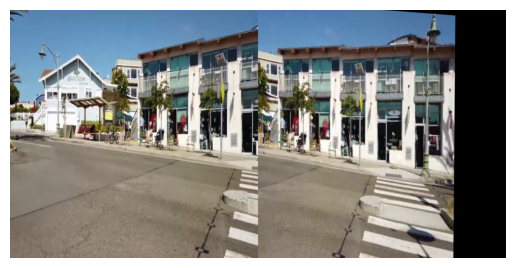

In [29]:
def image_stitching(origimg, origimg2, homography_matrix):

    stitched_img = cv2.warpPerspective(origimg2, homography_matrix, (origimg.shape[1] + origimg2.shape[1], origimg2.shape[0]))

    stitched_img[:origimg.shape[0], :origimg.shape[1]] = origimg

    return stitched_img

stitched_image = image_stitching(origimg, origimg2, homography_matrix)

plt.imshow(stitched_image)
plt.axis('off')
plt.show()